In [6]:
import numpy as np
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.mask import mask
import os
import matplotlib.pyplot as plt

In [52]:
#read the polygons
k45_mines = gpd.read_file("data/polygons/global_mining_polygons_v2.gpkg")

#set the column called 'geometry' as the geometry of the GeoPandas
k45_mines = k45_mines.set_geometry("geometry")
k45_mines = k45_mines.to_crs("EPSG:4326")

k45_mines.head()

,ISO3_CODE,COUNTRY_NAME,AREA,geometry
0,GBR,United Kingdom,1.782044,"POLYGON ((-1.67130 55.07660, -1.67040 55.07710..."
1,FJI,Fiji,0.023405,"POLYGON ((177.85480 -17.51730, 177.85490 -17.5..."
2,NZL,New Zealand,0.042758,"POLYGON ((175.87200 -37.34490, 175.87180 -37.3..."
3,FJI,Fiji,0.248552,"POLYGON ((177.84260 -17.51850, 177.84370 -17.5..."
4,FJI,Fiji,0.132724,"POLYGON ((177.84950 -17.49510, 177.84920 -17.4..."


In [84]:
type(k45_mines.iloc[1]['geometry'])


shapely.geometry.polygon.Polygon

### Get aggregated NTL Emissions
1. Get sorted list of files in 'data/viirs-tif/mosaic'
2. open and loop trough files and compute ntl-emissions sums for each intervall and each mine
3. append ntl-emissions for each intervall as cloumn to the polygon DataFrame

In [57]:
all_tif_mosaics = sorted(os.listdir('/Users/flurin/Downloads/mosaic/'))
all_tif_mosaics

#If list includes .DS_Store file move to directory in terminal and use <find . -name '.DS_Store' -type f -delete> to remove it

['2012-mosaic.tif',
 '2013-mosaic.tif',
 '2014-mosaic.tif',
 '2015-mosaic.tif',
 '2016-mosaic.tif',
 '2017-mosaic.tif',
 '2018-mosaic.tif',
 '2019-mosaic.tif',
 '2020-mosaic.tif',
 '2021-mosaic.tif']

In [ ]:
#i switched i with j !!!

for i in range(len(all_tif_mosaics)):
    file = all_tif_mosaics[i]
    #print('data/viirs-tif/mosaic/' + file)
    viirs_data = rasterio.open('/Users/flurin/Downloads/mosaic/' + file)

    agg_ntl = []

    for j in range(len(k45_mines)):
        active_polygon = k45_mines.iloc[j]

        crop_img, crop_transform = mask(viirs_data, shapes = [active_polygon['geometry']], crop=True)

        agg_ntl.append(np.sum(crop_img))

    k45_mines['agg_ntl_' + all_tif_mosaics[i][:4]] = agg_ntl

In [ ]:
#polygons.to_csv('ann_ntl_emiss_2012-2021')

### Get buffer values

##### Get UTM coordinates for all mines

In [ ]:
ntl_gdf = pd.read_csv('ann_ntl_emiss_2012-2021.csv')

In [22]:
utm_cord = k45_mines.copy()

for i in range(len(utm_cord)): #len(utm_cord)
    poly = utm_cord.iloc[[i]]
    est_epsg = poly.estimate_utm_crs()
    #print(est_epsg)
    utm_cord.iloc[[i]] = utm_cord.iloc[[i]].to_crs(crs=est_epsg)
    #print(i)

In [27]:
ntl_gdf['utm_geometry'] = utm_cord.geometry
#ntl_gdf.to_csv('utm_cord.csv')
ntl_gdf.head()

,Unnamed: 0,ISO3_CODE,COUNTRY_NAME,AREA,geometry,agg_ntl_2012,agg_ntl_2013,agg_ntl_2014,agg_ntl_2015,agg_ntl_2016,agg_ntl_2017,agg_ntl_2018,agg_ntl_2019,agg_ntl_2020,agg_ntl_2021,utm_geometry
0,0,GBR,United Kingdom,1.782044,"POLYGON ((-1.6713000000000005 55.0766, -1.6703...",339,253,246,212,188,184,170,182,116,101,"POLYGON ((584830.37258 6104121.99125, 584886.7..."
1,1,FJI,Fiji,0.023405,"POLYGON ((177.85479999999998 -17.5173, 177.854...",0,0,0,0,0,0,0,0,0,0,"POLYGON ((590737.14827 8063013.45245, 590747.3..."
2,2,NZL,New Zealand,0.042758,POLYGON ((175.87199999999999 -37.3448999999999...,0,0,0,0,0,0,0,0,0,0,"POLYGON ((400088.41580 5866268.99195, 400070.8..."
3,3,FJI,Fiji,0.248552,"POLYGON ((177.8426 -17.5185, 177.8436999999999...",9,16,12,8,17,41,49,18,28,19,"POLYGON ((589441.45116 8062886.45848, 589557.3..."
4,4,FJI,Fiji,0.132724,"POLYGON ((177.8495 -17.4951, 177.8492 -17.4956...",5,7,6,5,6,5,0,0,0,0,"POLYGON ((590185.47386 8065472.19220, 590153.3..."


##### Get shapes of mask of 2km radius

In [61]:
print(type(ntl_gdf.iloc[14]['utm_geometry']))
print(type(k45_mines.iloc[14]['geometry'))

<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>


<AxesSubplot:>

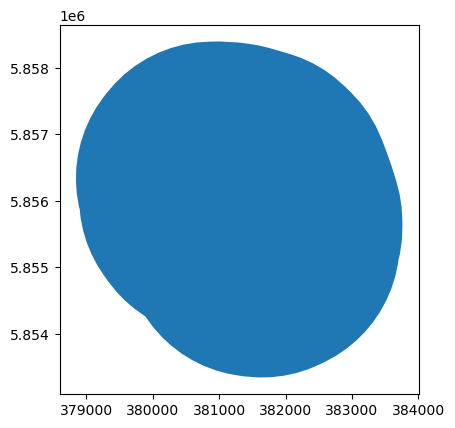

In [65]:
buffer = gpd.GeoSeries(ntl_gdf.iloc[14]['utm_geometry']).buffer(2000)
buffer.plot()

<class 'shapely.geometry.polygon.Polygon'>
<class 'geopandas.geoseries.GeoSeries'>


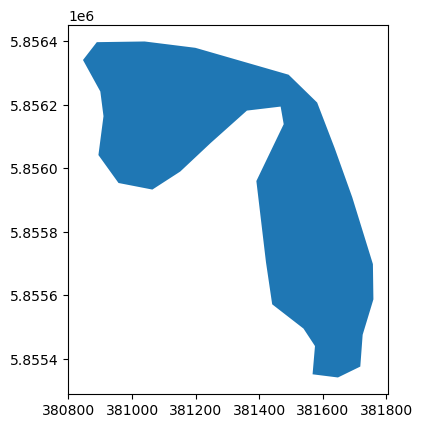

In [58]:
samplepoly_utm = ntl_gdf.iloc[14]['utm_geometry']
print(type(samplepoly_utm))
#buffer = gpd.GeoSeries(ntl_gdf.iloc[14]['utm_geometry']).buffer(2000)
p = gpd.GeoSeries(samplepoly_utm)
print(type(p))
p.plot()
plt.show()

<class 'geopandas.geoseries.GeoSeries'>


<AxesSubplot:>

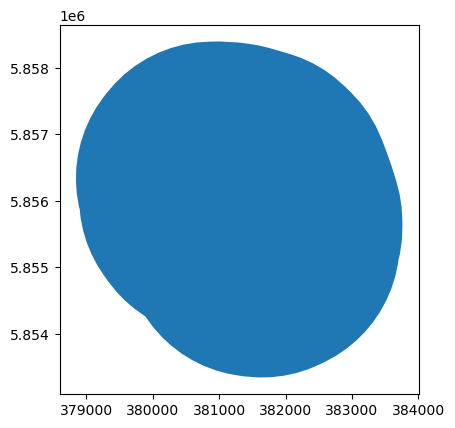

In [59]:
polygon_utm_buffer = p.buffer(2000) #2km buffer since utm is in m
print(type(polygon_utm_buffer))
polygon_utm_buffer.plot()

In [80]:
for i in range(1): #len(all_tif_mosaics)
    file = all_tif_mosaics[i]
    #print('data/viirs-tif/mosaic/' + file)
    viirs_data = rasterio.open('/Users/flurin/Downloads/mosaic/' + file)

    buff_2km_mean = []
    bugg_2km_std = []
    
    for j in range(10): #len(k45_mines)
        active_polygon = k45_mines.iloc[j]

        crop_img, crop_transform = mask(viirs_data, shapes = [gpd.GeoSeries(k45_mines.iloc[j]['geometry']).buffer(2000).difference(k45_mines.iloc[j]['geometry'])], crop=True)

        buff_2km_mean.append(np.mean(crop_img))
        bugg_2km_sd.append(np.std(crop_img))
        
        print(f'for mine nr. {j} in year {i} the 2km buffer mean is {np.mean(crop_img)} and the std is {np.std(crop_img)}')

    k45_mines['mean_2km_buff_' + all_tif_mosaics[i][:4]] = buff_2km_mean
    k45_mines['std_2km_buff_' + all_tif_mosaics[i][:4]] = buff_2km_mean

/Users/flurin/opt/anaconda3/lib/python3.9/site-packages/rasterio/features.py:324: ShapeSkipWarning: Invalid or empty shape {'type': 'FeatureCollection', 'features': [{'id': '0', 'type': 'Feature', 'properties': {}, 'geometry': {'type': 'Polygon', 'coordinates': (((-336.48479931161074, 2026.852429281517), (-200.00072036730882, 2043.2770619350038), (-147.62437661765244, 2049.752647183535), (-147.62027661765245, 2049.7529471835346), (-145.72881483553715, 2049.808198157331), (-144.181293611929, 2049.9944284328167), (-121.88473879907578, 2050.5047009536024), (27.60139321200645, 2054.8712995498454), (39.21314527884645, 2054.191540651109), (49.458969229209, 2054.4260236220684), (102.95065391484593, 2050.460308841369), (202.59820179928965, 2044.6268818941007), (223.8696214143358, 2041.495735384808), (242.61982796793075, 2040.1056507070166), (296.6217332730959, 2030.7866466068733), (376.02578730028216, 2019.0983939612881), (376.03358730028214, 2019.0968939612883), (403.9140457415955, 2012.27142

ValueError: No valid geometry objects found for rasterize

In [94]:
gpd.GeoSeries(k45_mines.iloc[j]['geometry']).buffer(2000).difference(k45_mines.iloc[j]['geometry'].plot()

SyntaxError: unexpected EOF while parsing (1834938263.py, line 1)

<AxesSubplot:>

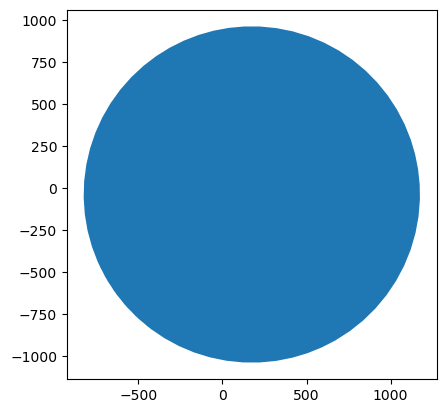

In [124]:
k45_mines.set_geometry('geometry')
gpd.GeoSeries(k45_mines.iloc[30]['geometry']).plot()#.difference(k45_mines.iloc[30]['geometry']).plot()

<AxesSubplot:>

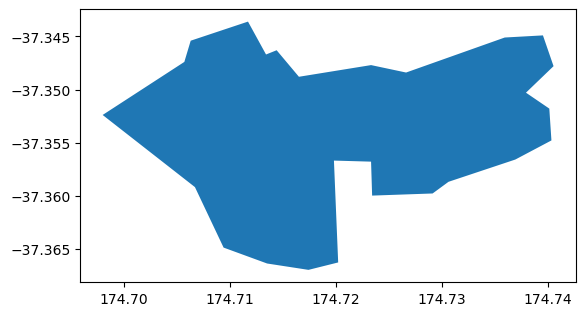

In [103]:
gpd.GeoSeries(k45_mines.iloc[30]['geometry']).plot()

In [ ]:
#ntl_gdf.to_csv('ann_ntl_emiss_2012-2021_utm')

<AxesSubplot:>

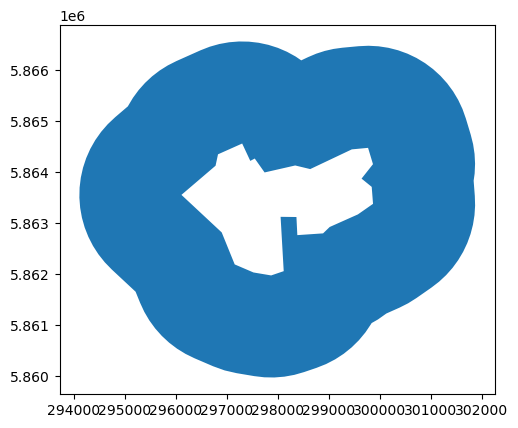

In [112]:
gpd.GeoSeries(ntl_gdf.iloc[30]['utm_geometry']).buffer(2000).difference(ntl_gdf.iloc[30]['utm_geometry']).plot()

In [69]:
all_tif_mosaics

['2012-mosaic.tif',
 '2013-mosaic.tif',
 '2014-mosaic.tif',
 '2015-mosaic.tif',
 '2016-mosaic.tif',
 '2017-mosaic.tif',
 '2018-mosaic.tif',
 '2019-mosaic.tif',
 '2020-mosaic.tif',
 '2021-mosaic.tif']

In [71]:
tif_2012 = rasterio.open('/Users/flurin/Downloads/mosaic/2012-mosaic.tif')

In [72]:
tif_2012.crs

CRS.from_epsg(4326)